# Purchase Journey Analysis

This notebook focuses on users who eventually make a purchase, analyzing all their sessions leading up to that purchase event using previously defined categories.

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Load the same dataset as in sessions_deepdive.ipynb
df = pd.read_csv('analytics.csv')

# Set the same colors as in the original notebook for consistency
colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
facecolor = '#F5F5F5'

In [58]:
def domainToName(str):
    name = str.split('.')[0]
    if name == "hm": return "H&M"
    return name.capitalize()


## Individual User Purchase Journey Visualization

To better understand the specific path users take before making a purchase, let's visualize individual user journeys. This will show us the sequence of session types that lead to a purchase event.

In [59]:
# Select a few interesting users with multiple sessions before purchase for case studies
# We'll look for users with different patterns to show variety in purchase journeys

df = pd.read_csv('analytics.csv')
df['timestamp'] = pd.to_datetime(df['created_at'], format='ISO8601')
only_show_events = ['place-order', 'enforce_wait_modal_shown', 'active', 'add-to-cart', 'uninstall', 'checkout', 'page-view']
interesting_df = df[df['type'].isin(only_show_events)]
# Find users with multiple pre-purchase sessions (3+) for more interesting journeys
# Group data by user_id and analyze their journey
buying_session_ids = df[df['type'].isin(['enforce_wait_modal_shown', 'place-order'])]['session_id'].unique()

# Filter out sessions that are not in the buying session IDs
sessions_df = interesting_df[interesting_df['session_id'].isin(buying_session_ids)]


print(len(buying_session_ids))


16


In [60]:
# ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']  [s, D, o, X]
# Determine session type color and marker
# Create a lookup dictionary for event styling
event_styles = {
    'enforce_wait_modal_shown': {'color': 'salmon', 'marker': 's', 'size': 150, 'zorder': 5},
    'place-order': {'color': '#000', 'marker': '|', 'size': 300, 'zorder': 20},
    'add-to-cart': {'color': '#106ED3', 'marker': 'x', 'size': 100, 'zorder': 25},
    'checkout': {'color': '#73FABD', 'marker': 'D', 'size': 100, 'zorder': 10},
    'page-view': {'color': '#6ED1F8', 'marker': '.', 'size': 80, 'zorder': 20},
    'workaround': {'color': '#000', 'marker': '|', 'size': 300, 'zorder': 20}
}

session_timelines = []
for buying_session in buying_session_ids:
    # Prepare data for visualization
    timeline_data = []
    session_df = df[df['session_id'] == buying_session].copy()
    for _, session in session_df.iterrows():
        time_from_first = (session['timestamp'] - session_df['timestamp'].min()).total_seconds()

        workaround = None

        # differentiate between active and deactivate by assessing payload == 'true'
        if session['type'] == 'uninstall':
            workaround = 'Uninstall'
        elif session['type'] == 'active':
            if session['payload'] == 'true':
                workaround = 'Activate'
            else:
                workaround = 'Deactivate'

        # Apply the styling based on session type
        if session['type'] in event_styles:
            style = event_styles[session['type']]
            color, marker, size, zorder = style['color'], style['marker'], style['size'], style['zorder']
        elif workaround:
            style = event_styles['workaround']
            color, marker, size, zorder = style['color'], style['marker'], style['size'], style['zorder']
        else:  continue

        timeline_data.append({
            'session_id': session['session_id'],
            'user_id': session['user_id'],
            'type': session['type'],
            'timestamp': session['timestamp'],
            'time': time_from_first,
            'domain': session['domain'],
            'workaround': workaround,
            'color': color,
            'marker': marker,
            'size': size,
            'zorder': zorder
        })

    # Adjust x-coordinates for better spacing when events are too close
    # Sort by time
    timeline_data.sort(key=lambda x: x['time'])
    session_timelines.append(timeline_data)

In [61]:
# Sort the session_timelines by the user_id of the first event in each timeline
session_timelines.sort(key=lambda timeline: timeline[0]["user_id"] if timeline else "")
print("Sorted session_timelines by user_id")

# Replace user_id with A, B, C ...
# Create a mapping of user_ids to letters
unique_users = set()
for timeline in session_timelines:
    if timeline:  # Make sure the timeline is not empty
        unique_users.add(timeline[0]["user_id"])

user_id_to_letter = {user_id: chr(65 + i) for i, user_id in enumerate(sorted(unique_users))}

# Replace user_ids in all timelines
for timeline in session_timelines:
    for event in timeline:
        event["original_user_id"] = event["user_id"]
        if event["user_id"] in user_id_to_letter:
            event["user_id"] = user_id_to_letter[event["user_id"]]


# reverse order of session_timelines
session_timelines = session_timelines[::-1]
print("Reversed order of session_timelines")

print(f"Replaced {len(user_id_to_letter)} unique user_ids with letters")


Sorted session_timelines by user_id
Reversed order of session_timelines
Replaced 9 unique user_ids with letters


In [62]:
# Remove multiple modal_shown in a row

for i, timelines in enumerate(session_timelines):
    new_timeline = []
    last_modal_time = None
    
    for event in timelines:
        if event["type"] != "enforce_wait_modal_shown":
            new_timeline.append(event)
            continue

        if last_modal_time != None and event["time"] - last_modal_time < 120:
            continue

        last_modal_time = event["time"]
        new_timeline.append(event)

        
    session_timelines[i] = new_timeline

print("Remove repeated modal_shown")

Remove repeated modal_shown


Session Homedepot: 7ff58d7c-0501-4db4-b082-ea5365768794 I
Session Amazon: 0109904a-058e-44e9-9387-c1d376e50ced H
Session Amazon: b24aeb5a-54cf-4b50-b6f2-8801d3dfcb77 H
Session Etsy: 197988fa-c7cf-456f-a177-35fe9809bcab H
Session Shop: ba0ecaf3-3891-40d8-8842-9affdb74f136 H
Session Shop: 0aff5ca5-8d1c-42da-9585-ad0b3ea57829 G
Session Shop: c2988ad4-016e-454c-bc36-81a53427e790 G
Session Ikea: 312878ed-4222-4367-9ecc-33d0ee262a10 F
Session Apple: 34447114-fe42-4bee-97fd-02b62030e495 E
Session Walgreens: 82401c51-47c0-4140-8e70-054f82061319 D
Session Proshop: ef7f1531-3eff-4a65-808b-77723a502669 C
Session Zalando: fe5c8a93-7210-4a53-b474-8179f6fdd925 B
Session Zalando: f01e2939-966a-410f-8efb-dc2ef60282d4 B
Session Amazon: 80746601-82b1-421b-9b85-51b58e9ee0af B
Session Amazon: b4c51f7e-ec0b-49d5-88db-0dd1abbc20f4 B
Session Zara: 29ba2a9f-5341-44ea-a430-42becf7ff8fe A


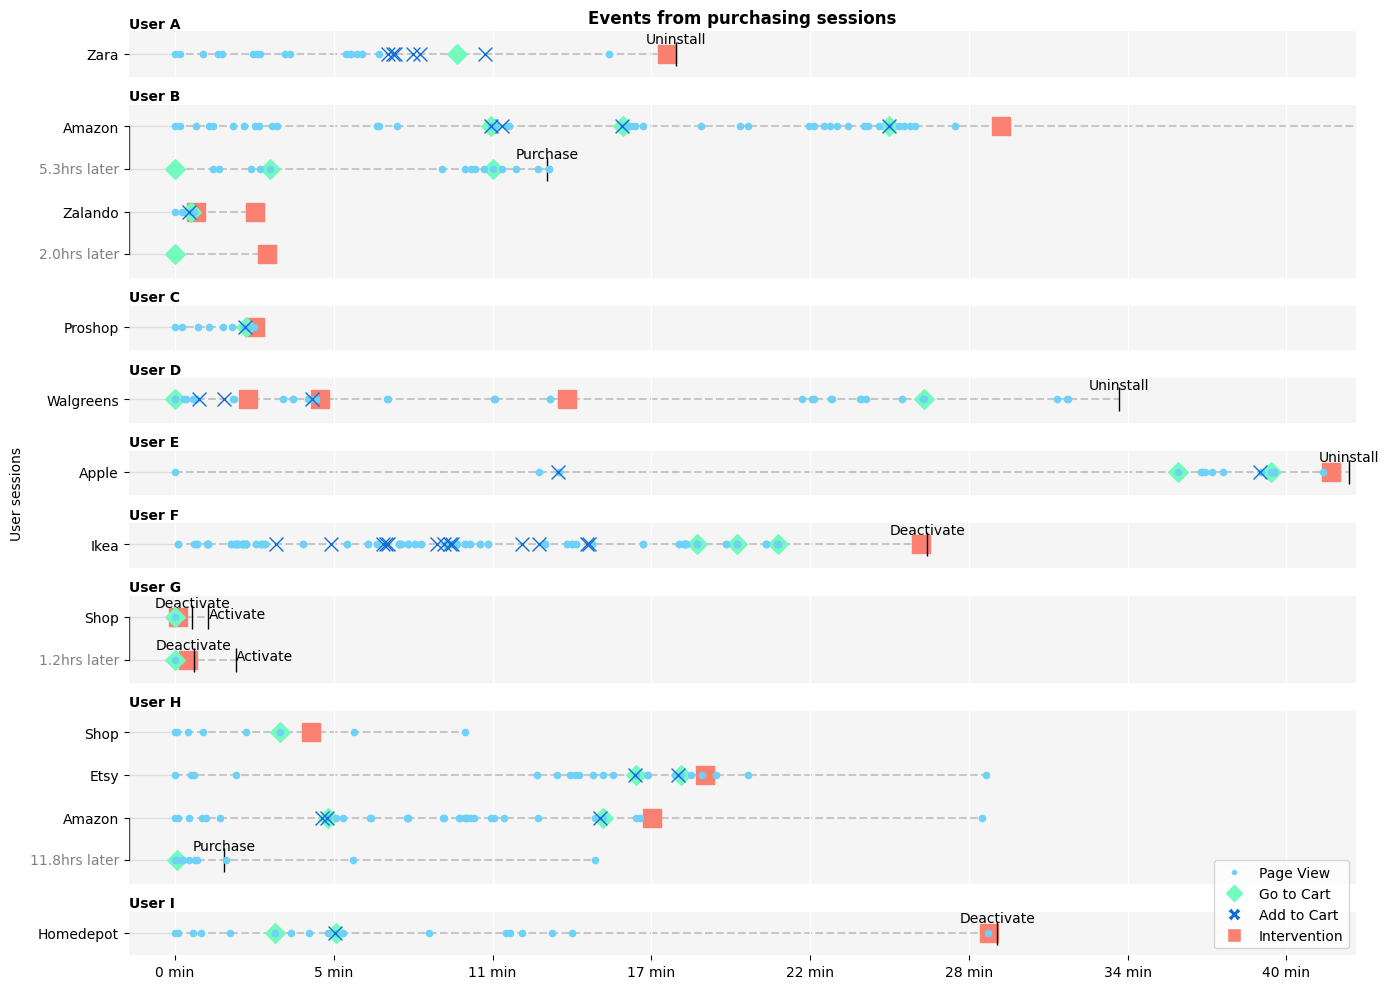

In [63]:
num_sessions = len(session_timelines)

vertical_spacing = 0.12
unique_users = len(set(event['user_id'] for timeline in session_timelines for event in timeline))
user_gap = 0.08
height = num_sessions * vertical_spacing + (unique_users - 1) * user_gap

# Calculate vertical spacing for each user
y_positions = np.linspace(0.2, num_sessions * vertical_spacing, num_sessions)
user_gaps_y = []

last_user_id = session_timelines[0][0]["user_id"]
accumuldated_user_gap = 0
for i in range(num_sessions):
    uid = session_timelines[i][0]["user_id"]
    if uid != last_user_id:
        accumuldated_user_gap += user_gap
        user_gaps_y.append(y_positions[i] + accumuldated_user_gap - (user_gap + vertical_spacing) / 2)
        
    last_user_id = uid
    y_positions[i] += accumuldated_user_gap

session_y_map = {session_timelines[i][0]['session_id']: y_pos for i, y_pos in enumerate(y_positions)}


plt.figure(figsize=(14, 10))

# First pass: plot the connecting lines for each user
for session_timeline in session_timelines:
    session_id = session_timeline[0]['session_id']
    max_time = session_timeline[-1]['time']
    y_pos = session_y_map[session_id]

    # Connect points with lines
    plt.plot([0, max_time], [y_pos, y_pos], '--', color="gray", alpha=0.4, zorder=0)

    for event in session_timeline:
        plt.scatter(
            event['time'], 
            y_pos,  # Fixed y-position for timeline
            color=event['color'],
            s=event['size'],
            marker=event['marker'],
            zorder=event['zorder'],
            linewidth=1
        )

        if event['workaround']:
            ha = 'center' if event['workaround'] != 'Activate' else 'left'
            pos_offset = 0.02 if event['workaround'] != 'Activate' else -0.01
            plt.text(
                event['time'],
                y_pos + pos_offset,  # Increased vertical positionion
                event['workaround'],
                ha=ha,
                va='bottom',
                fontsize=10,  # Slightly larger font
                color='black',
            )

        if event['type'] == "place-order":
            plt.text(
                event['time'],
                y_pos + 0.02,  # Increased vertical positionion
                "Purchase",
                ha='center',
                va='bottom',
                fontsize=10,  # Slightly larger font
                color='black',
            )

# Add grid lines for each user's position
y_padding = 0.06
plt.ylim(0.2 - y_padding, height + y_padding)
for y_pos in y_positions:
    plt.plot([-100, 0], [y_pos, y_pos], color='lightgray', alpha=0.7, linewidth=1, zorder=1)
    #plt.line(y=y_pos, color='lightgray', linestyle='-', alpha=0.3, zorder=2)


# Add session labels on the y-axis
start = num_sessions - 1
#session_labels = [f'User {session_timelines[i][0]["user_id"]}' for i in range(num_sessions)]  # A, B, C, etc.
session_labels = [f'{domainToName(session_timelines[i][-2]["domain"])}' for i in range(num_sessions)]  # A, B, C, etc.
plt.yticks(y_positions, session_labels)
plt.ylabel("User sessions", labelpad=10)


x_lim_min = -100

# Add domain labels underneath the session labels
"""for i, session_timeline in enumerate(session_timelines):
    domain = domainToName(session_timeline[0]['domain'])
    plt.text(
        x_lim_min-20,  # Place text to the left of the y-axis
        y_positions[i] - .05,
        domain,
        ha='right',
        va='center',
        color='gray',
        fontsize=10,
    )"""

seen_uids = set()

for i, session_timeline in enumerate(reversed(session_timelines)):
    uid = session_timeline[0]['user_id']
    reversed_i = num_sessions - 1 - i
    
    # Only display domain for first time we see this user
    if uid not in seen_uids:
        plt.text(
            x_lim_min,  # Place text to the left of the y-axis
            y_positions[reversed_i] + .08,
            f"User {uid}",
            ha='left',
            va='center',
            fontweight="bold",
            fontsize=10,
        )
        seen_uids.add(uid)

# Add time between
for i in range(len(session_timelines)-1):
    if session_timelines[i][0]['domain'] != session_timelines[i+1][0]['domain'] or session_timelines[i][0]['user_id'] != session_timelines[i+1][0]['user_id']:
        continue
    first_event = session_timelines[i+1][0]["timestamp"]
    last_event = session_timelines[i][-1]["timestamp"]
    time_from_first = (first_event - last_event).total_seconds() / 3600
    
    plt.text(
        x_lim_min - 20,  # Place text in a fixed position
        y_positions[i],
        f"{abs(time_from_first):.1f}hrs later",
        bbox=dict(boxstyle="square", facecolor="white", edgecolor="none", alpha=1),
        ha='right',
        va='center',
        color='gray',
        fontsize=10,
    )

    plt.plot([x_lim_min, x_lim_min], [y_positions[i], y_positions[i+1]], color='black', alpha=0.7, linewidth=1, zorder=1)

# Add some white inbetween users to make them stand out
for y in user_gaps_y:
    plt.plot([x_lim_min, 2550], [y, y], color='white', linestyle='-', linewidth=20, zorder=2)

for i in range(num_sessions):
    print(f"Session {session_labels[i]}: {session_timelines[i][0]['session_id']} {session_timelines[i][0]['user_id']}")


x_positions = np.linspace(0, 2400, 8)

# Convert seconds to minutes and format as integer values
minute_labels = [f'{int(x/60)} min' for x in x_positions]
plt.xticks(x_positions, minute_labels)
plt.xlim(x_lim_min, 2550)


# Set up the plot with improved aesthetics
plt.title(f'Events from purchasing sessions', fontweight='bold')

# Create legend elements based on event_styles
legend_elements = [
    plt.Line2D([0], [0], marker=event_styles['page-view']['marker'], color='w', 
               markerfacecolor=event_styles['page-view']['color'], 
               markersize=10, label='Page View'),
    plt.Line2D([0], [0], marker=event_styles['checkout']['marker'], color='w', 
               markerfacecolor=event_styles['checkout']['color'], 
               markersize=10, label='Go to Cart'),
    plt.Line2D([0], [0], marker='X', color='w', 
               markerfacecolor=event_styles['add-to-cart']['color'], 
               markersize=10, label='Add to Cart'),
    plt.Line2D([0], [0], marker=event_styles['enforce_wait_modal_shown']['marker'], color='w', 
               markerfacecolor=event_styles['enforce_wait_modal_shown']['color'], 
               markersize=10, label='Intervention'),
]
plt.legend(handles=legend_elements, loc='lower right')





ax = plt.gca()
#ax.grid(color='white', linewidth=1, axis='y', alpha=0, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=2)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig('plots/purchasing_session_events_all.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
user_time = []

for timeline in session_timelines:
    first_intervention_time = None
    intervention_event = None
    for event in timeline:
        if event['type'] == 'enforce_wait_modal_shown':
            first_intervention_time = event['timestamp'] - timeline[0]['timestamp']
            intervention_event = event
            break

    if not first_intervention_time:
        continue
    
    timeline_type = "abandon"
    for event in timeline:
        if event['type'] == 'place-order':
            timeline_type = "purchase"
            break
    
    for event in timeline:
        if event['type'] == 'active' or event['type'] == 'uninstall':
            timeline_type = "workaround"
            break


    domain = timeline[-2]['domain']
    if domain == "shop.app":
        continue

    user_id = timeline[0]['original_user_id']

    user_df = df[df['user_id'] == user_id]
    sorted_modal_shown = user_df[user_df['type'] == 'enforce_wait_modal_shown'].sort_values(by='created_at')
    first_modal_shown = sorted_modal_shown.iloc[0]

    user_time.append({
        "user_id": user_id,
        "session_id": timeline[0]['session_id'],
        "domain": timeline[-2]['domain'],
        "time": timeline[-1]['timestamp'] - timeline[0]['timestamp'],
        "first_intervention_time": first_intervention_time,
        "first_intervention_experience": first_intervention_time,
        "timeline_type": timeline_type,
        "is_first_intervention": first_modal_shown['timestamp'] == intervention_event['timestamp'],
    })

user_time_df = pd.DataFrame(user_time)
workaround_df = user_time_df[user_time_df['timeline_type'] == 'workaround']
abandon_df = user_time_df[user_time_df['timeline_type'] == 'abandon']


workaround_stats = workaround_df['first_intervention_time'].agg(['min', 'median', 'mean', 'max'])
abandon_stats = abandon_df['first_intervention_time'].agg(['min', 'median', 'mean', 'max'])

def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    minutes, seconds = divmod(total_seconds, 60)
    if minutes == 0:
        return f"{seconds}s"
    return f"{minutes}m{seconds:02d}s"

workaround_stats = workaround_stats.apply(format_timedelta)
abandon_stats = abandon_stats.apply(format_timedelta)

print("Workaround - Min:", workaround_stats['min'], "Median:", workaround_stats['median'], "Max:", workaround_stats['max'], "Mean:", workaround_stats['mean'], "Amount", len(workaround_df))
print("Abandon - Min:", abandon_stats['min'], "Median:", abandon_stats['median'], "Max:", abandon_stats['max'], "Mean:", abandon_stats['mean'], "Amount", len(abandon_df))

print(f"""
        \\textbf{{Amount}} & {len(workaround_df)} & {len(abandon_df)} \\\\
        \\textbf{{First encounter}} & {len(workaround_df[workaround_df["is_first_intervention"]])} & {len(abandon_df[abandon_df["is_first_intervention"]])} \\\\
        \\textbf{{Mean}} & {workaround_stats['mean']} & {abandon_stats['mean']} \\\\
        \\hline
        \\textbf{{Min}} & {workaround_stats['min']} & {abandon_stats['min']} \\\\
        \\textbf{{Median}} & {workaround_stats['median']} & {abandon_stats['median']} \\\\
        \\textbf{{Max}} & {workaround_stats['max']} & {abandon_stats['max']} \\\\
""")

Workaround - Min: 2m37s Median: 26m43s Max: 41m37s Mean: 23m35s Amount 5
Abandon - Min: 46s Median: 10m14s Max: 29m42s Mean: 12m09s Amount 6

        \textbf{Amount} & 5 & 6 \\
        \textbf{First experience} & 5 & 2 \\
        \textbf{Mean} & 23m35s & 12m09s \\
        \hline
        \textbf{Min} & 2m37s & 46s \\
        \textbf{Median} & 26m43s & 10m14s \\
        \textbf{Max} & 41m37s & 29m42s \\



In [ ]:

In this section, we present the results from our intervention extension experiment. The experiment ran for a total of eight weeks, involving $61$ users who generated $13,391$ data points across various analytic events.

Participation in the experiment was determined by the timing of each user's installation and uninstallation of the extension. Figure~\ref{fig:accumulated-installs} shows cumulative installs and uninstalls, indicating the number of active users over time. In total, $61$ users participated, of whom $31$ uninstalled and $2$ deactivated the extension, leaving $28$ active users at the time of writing. On average, $18.5$ active users contributed data throughout the experiment. The rapid rise in installations during the first two weeks reflects our concentrated marketing efforts. Subsequent installs were largely the result of Reddit exposure.


Many sessions originated from a small subset of highly active users, as shown in Figure~\ref{fig:boxplotsessionperuser}. While most users recorded between 1 and 4 sessions (mean: 3.7, median: 1), the top eight users were responsible for $60\%$ of all sessions. These frequent users offered deeper insights into the behavior of consistently engaged participants but may not represent average consumer behavior.

The three most visited domains were Amazon, IKEA, and Etsy, accounting for $52.7\%$ of total page views. A full breakdown of page views, add-to-cart events, go-to-cart sessions, and interventions can be found in Appendix~\ref{tab:experiment-data-full}.

We next examine how the extension influenced user behavior. Figure~\ref{fig:userjourneygraph} illustrates $30$ user journeys involving either an add-to-cart event or a cart inspection. Since purchasing processes may span multiple sessions, each journey represents a unique user-domain pair over the entire experiment. In cases where no add-to-cart event was logged for a cart visit, we synthetically added the event to compensate for missing analytics on unsupported or partially supported sites. As a result, most journeys include a go-to-cart event.

Of the $29$ journeys that reached the cart, only $13$ were intervened by the extension. This suggests that users often abandoned carts on their own, or that certain checkouts were not successfully intervened. Among the 13 intervened cases, $54\%$ led to users disabling or uninstalling the extension, $30\%$ to cart abandonment, and $16\%$ to delayed purchases. These figures may under-represent abandonment due to untracked workarounds. Notably, one user who disabled the extension later reactivated it, indicating a willingness to follow its restrictions except in specific cases.


To explore these behaviors further, Figure~\ref{fig:purchasingsessions} presents a timeline of $11$ out of $16$ sessions involving a purchase or intervention. Additional sessions are available in Appendix~\ref{sec:appendix_all_purchasing_sessions}.


The plot reveals two cases where users waited before purchasing (User B \& G on Amazon), three cases of abandonment following an intervention (User B on Zara, C on Proshop \& G on Etsy), and three instances of users circumventing the extension via uninstallation or deactivation (User A, D, \& E).

Users B, C, and G appear to have respected the extension’s intent by either delaying or ultimately abandoning their purchases. These cases suggest the extension can be effective for certain user types. In contrast, User D added more items to their cart after being shown the wait-time modal, implying the intervention may have inadvertently increased consumption for this user.

In six out of seven circumvention cases, the intervention was encountered for the first time, prompting immediate removal of the extension, expect User D, who waited nearly 30 minutes before uninstalling. This behavior suggests that many users were strongly committed to completing their purchase at the time of intervention.

Uninstallers typically had sessions lasting over 18 minutes and spent between 2.5 and 12 minutes in the checkout process before being intervened. This raises the question of whether intervening earlier could have led to different outcomes.


We hypothesize that longer sessions are correlated with a higher likelihood of workarounds. To test this, we excluded Shopify checkouts lacking full shopping process data and measured the time from buying session’s first event to the first point of intervention. Results are summarized in Table~\ref{tab:longer-sessions-uninstall}.

The difference between workaround and non-workaround is about 2-fold, signaling that the workaround sessions are typically longer, but we cannot conclude anything given the size of dataset, and that all workarounds happen on users first experience with the extension, as opposed to the non-workarounds.

The average session time before intervention was nearly twice as long in workaround cases compared to non-workarounds. However, conclusions are limited due to the small sample size and the fact that all workarounds occurred during users’ first encounter with the intervention as opposed to non-workaround, which only includes two.\footnote{The number of first-time encounters among non-workaround users is lower than expected due to the exclusion of Shopify checkouts from this analysis. Two users had their initial intervention on a Shopify domain and were therefore not counted in this comparison.}

Only one participant (User G from Figure~\ref{fig:purchasingsessions}) completed the feedback survey, after being prompted eight times via pop-ups. They rated the extension’s impact on mindful purchasing at $3$ out of $5$. They reported using no workarounds, acknowledged abandoning a purchase due to the extension, but also found the experience frustrating. This aligns with broader observations: while some users appear to decrease purchasing online after being intervened (Users B, C, \& G), the intervention is not perceived as effective at making users more mindful about their purchases, especially among those who uninstalled the extension.

This reflects a two-sided finding observed throughout the experiment. On one hand, certain users (e.g., Users B, C, and G) demonstrably abandoned their carts following interventions, suggesting a reduction in online purchasing behavior. This is further supported by User G’s self-report of having abandoned a purchase due to the extension. On the other hand, the high uninstall and circumvention rate, indicate that the extension is not broadly perceived as a tool for fostering more mindful or reflective shopping decisions. These findings highlight a tension between the two hypotheses underpinning this study: that the intervention can reduce impulsive purchasing, and that it can promote more deliberate, reflective consumption. While there is evidence point in both direction, we cannot conclude anything given the sparse dataset.

User retention proved to be a significant challenge, with $31$ out of $60$ users uninstalling the extension. As seen in Figure~\ref{fig:instant_uninstalls}, 75\% of these uninstalls occurred within the first five minutes. These users typically went untracked due to the blackout period or use of unsupported sites.


Among users who did engage, the median number of sessions before uninstalling was $2$. Some users installed the extension, visited a shopping site to test it, and uninstalled shortly afterward due to a lack of visible effect. This underscores the importance of immediately noticeable functionality for Chrome extensions to improve retention.

This pattern is further supported by self-reported uninstallation reasons, collected immediately after users removed the extension (see Table~\ref{tab:uninstall_reasons}). 

Self-reported reasons for uninstalling (Table~\ref{tab:uninstall_reasons}) further highlight this issue. One user with zero recorded events from supported websites cited the extension as \textit{Not Useful}. Similarly, reasons such as \textit{Privacy Concerns} were reported by users who never triggered any analytics events, suggesting that the absence of visible functionality may lead to heightened suspicion about privacy. Finally, although one user reported the extension as \textit{Too Annoying}, this response is not considered further, as the user did not encounter the intervention.